# Assignment 6
### Kasper Fyhn Jacobsen

I have tried to expand a bit on the Transcript class from last time and, in fact, I have started to play with making an actual module that can be used in extracting information from CHILDES transcripts. Since we have worked with Brown's longitudinal studies so far, some of the things that I have tried to do works mainly for these longitudinal studies, but other parts are generalizable for other purposes as well.

## The Transcript class
First off, here is the class definition itself with just a few additions and corrections from last time, so you  will probably not need to pay too much attention to that. This constitutes the core of the module since almost everything is and will be based on the functionality of this class.

In [2]:
import os
from collections import Counter
from string import punctuation as pnc

class Transcript:
    '''This class is a representation of a transcript following the norm from
    the CHILDES database. As long as the raw transcript file follows that norm,
    all kinds of informations and extractions from the transcript should be
    obtainable through the class methods and variables.'''  
    
    def __init__(self, filepath):        
        try:
            file = open(filepath, 'r', encoding='utf-8')
            self.name = os.path.basename(file.name)
            
            # store the raw transcript, but clean it a little bit
            self.raw_transcript = file.read()
            remove_list = ['\t', '\r']
            for item in remove_list:
                self.raw_transcript = self.raw_transcript.replace(item, '')
                
            # extract headerlines and transcriptlines
            text = self.raw_transcript.split('\n')
            self.headers = [line for line in text if line.startswith('@')]
            self.lines = [line for line in text if line.startswith('*')]
            self.fully_loaded = True # flag that transcript is fully loaded
            
        except IOError as e:
            self.fully_loaded = False # flag that transcript was not loaded
            print('An error occured when loading:', filepath)
            print('Error message:', e)
    
    def lines_as_tuples(self):
        '''Return a list of tuples of all utterance lines, where tuple[0] is
        the three letter initials for the speaker and tuple[1] is the line.'''
        
        return [(line[1:4], line[5:]) for line in self.lines]
    
    def tokens(self, speakers='all'):
        '''Return a list of tokens uttered by the specified speaker(s). If no
        speakers are specified, return tokens for all speakers.'''
        
        if speakers == 'all':
            speakers = self.speakers()
        
        if type(speakers) == str:
            speakers = [speakers]
        
        # check if the requested speakers are present in the transcript
        for speaker in speakers:
            if speaker not in self.speakers():
                print(f'WARNING: The speaker {speaker} is not present ' +
                      f'in the transcript {self.name}.')             
            
        # get tokens from the specified speakers
        tokens = [word.lower()
                  for tpl in self.lines_as_tuples() if tpl[0] in speakers
                  for word in tpl[1].split()]
        
        # clean for punctuation
        tokens = ' '.join(tokens)
        tokens = ''.join(c for c in tokens if c not in pnc)
        tokens = tokens.split()
        
        return tokens
    
    def types(self, speakers='all'):
        '''Return a list of types uttered by the specified speaker(s). If no
        speakers are specified, return types for all speakers.'''
        
        return set(self.tokens(speakers=speakers))
    
    def ttr(self, speakers='all', disregard=[]):
        '''Return the type-to-token-ratio of the transcript in whole. Pass
        specific speaker(s) to get it for only that/these speaker(s). A list of
        words to be disregarded in the calculation, e.g. function words, can be
        passed if needed.'''
        
        tokens = [word for word in self.tokens(speakers=speakers)
                  if word not in disregard]
        types = set(tokens)
        
        return len(types) / len(tokens)
    
    def word_freqs(self, speakers='all'):
        '''Return a Counter object of tokens uttered by the specified
        speaker(s). If no speakers are specified, return a Counter object for
        all speakers.'''
        
        return Counter(self.tokens(speakers=speakers))
    
    def prop_word_freqs(self, speakers='all'):
        '''Return a dict of words and their proportional frequencies.'''
        
        # get number of tokens and a list of tuples with words and frequencies
        freqs = self.word_freqs(speakers=speakers)
        tokens = sum(freqs.values()) 
        freqs = freqs.most_common()
        
        # make a dict with the word as key and prop freq as value
        prop_freqs = {word[0]:word[1]/tokens for word in freqs}
    
        return prop_freqs
    
    def speakers(self):
        '''Return a set of all speakers that appear in the transcript'''

        return {line[1:4] for line in self.lines}
    
    def speaker_details(self):
        '''Return a dictionary of dictionaries containing details about the
        given speaker(s). If no info is given in the original transcript file
        on some details, e.g. age or sex, those entries will simply be empty.
        The entries are: lang, corp, name, age, sex, role. As an example, the
        child's age is called by transcript.speaker_details()['CHI']['age']'''
        
        # find the ID lines from the header lines and split these
        ids = [id_str for id_str in self.headers if id_str.startswith('@ID')]
        ids = [entry[4:].split(sep='|') for entry in ids]
        
        # assign the values to their respective dict entries
        ids = [{'lang':entry[0], 'corp':entry[1], 'name':entry[2],
                'age':entry[3], 'sex':entry[4], 'role':entry[7]}
                for entry in ids]
        
        # create a dict with names as keys and the dicts as values
        ids = {entry['name']:entry
               for entry in ids if entry['name'] in self.speakers()}
                
        return ids

## Some useful functions
This could, of course, be a never-ending list, but here are just two examples of useful functions in the next part but also, and maybe more importantly, useful in the future: 1) a function which returns a list of loaded Transcript objects from a given directory and 2) an age converter because, I guess, quite often we will want a child's age in months rather than in y;mm.dd.

In [3]:
import glob

def load_all_from_dir(dirname):
    '''Return a list of Transcript objects loaded from the given directory
    sorted after file names. The directory name should be stated either as
    relative path from the working directory or as an absolute path.'''
    
    prev_dir = os.getcwd()
    os.chdir(dirname)
    
    # load all transcripts from the folder and clean out non-loaded ones
    trans = [Transcript(file) for file in glob.glob('*.cha')]
    trans = [trn for trn in trans if trn.fully_loaded]
    
    # make sure the list is sorted
    trans.sort(key=lambda x: x.name)
    
    os.chdir(prev_dir)
    
    return trans

def age_in_months(age):
    '''Return an age passed in the format y;mm.dd as the number of months with
    two decimal numbers.'''
    
    # split the passed age string at the specified characters
    y_md = age.split(';')
    m_d = y_md[1].split('.')
    
    # convert each number to a float
    years = float(y_md[0])
    months = float(m_d[0])
    # in case days is not specified, assign 0
    try:
        days = float(m_d[1])
    except:
        days = 0
    
    # calculate number of months
    total = years * 12 + months + days / 30
    
    return float(f'{total:.2f}')

## Plotting word frequencies and TTR
I know we have talked a lot about word frequency and TTR already, but I wanted to try plotting with matplotlib, and so these two measures made decent candidates of measures. This makes us able to see changes over time in longitudinal studies. Let's try out some different things on a longitudinal study by Stan Kuczaj with the child Abe:

In [4]:
folder = '/Users/kasperfyhnjacobsen/Dropbox/Child Language Acquisition/Data/Kuczaj'
transcripts = load_all_from_dir(folder)

Last week, we worked with getting some data into a .csv file. We could, of course, just plot the data in Excel, but as mentioned, I wanted to try to work with matplotlib to plot some data. So, let's try to plot some word frequencies.

In [5]:
import matplotlib.pyplot as plt

def plot_word_freqs(words, transcripts, speaker='CHI'):
    '''Show a plot of proportional frequencies for each given word with the age
    of the child in months on the x-axis.'''
    
    if type(words) == str:
        words = [words]
    
    # get ages from all transcripts and convert these to months
    ages = [trn.speaker_details()['CHI']['age'] for trn in transcripts]
    ages = [age_in_months(age) for age in ages]
    
    # for each word, get and plot the prop freq with a color and a label
    for word in words:
        word_freqs = [trn.prop_word_freqs(speakers=speaker)[word]
                      if word in trn.tokens(speakers=speaker)
                      else 0
                      for trn in transcripts]        
        plt.plot(ages, word_freqs, '^', label=word)
    
    # make it pretty and show the plot
    plt.title('Word frequencies over time')
    plt.xlabel('Age in months')
    plt.ylabel('Proportional word frequency')
    plt.legend()
    plt.show()
    
    return

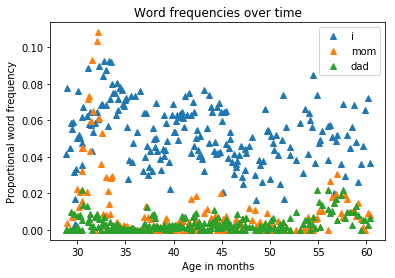

In [6]:
plot_word_freqs(['i', 'mom', 'dad'], transcripts)

However, this does not show us very much (at least not to me). Maybe looking at specific groups of words can tell us more. The Natural Language Toolkit (NLTK) has a list of word of what they call stopwords. These include all kinds of functions words. One could suspect that, as the child gets older, these words get more frequent. Let's see if this holds on a plot. First, let's define a function that plots the frequency of wordgroups rather than single words.

In [7]:
def plot_wordgroup_freq(wordgroup, transcripts, speaker='CHI', 
                        label='wordgroup'):
    '''Show a plot of the summed proportional frequencies of a given wordgroup
    with the age of the child in months on the x-axis.'''
    
    # get ages from all transcripts and convert these to months
    ages = [trn.speaker_details()['CHI']['age'] for trn in transcripts]
    ages = [age_in_months(age) for age in ages]
    
    # make a list of the sums of word frequencies of words in the group
    word_freqs = []
    for trn in transcripts:
        prop_freqs = trn.prop_word_freqs(speakers=speaker)
        tokens = trn.tokens(speakers=speaker)
        wordgroup_freqs = [prop_freqs[word] if word in tokens else 0
                           for word in wordgroup]
        word_freqs.append(sum(wordgroup_freqs))
    
    # make and show the plot
    plt.plot(ages, word_freqs, '^')
    plt.title(f'Word frequencies over time for {label}')
    plt.xlabel('Age in months')
    plt.ylabel('Proportional word frequency')
    plt.show()
    
    return

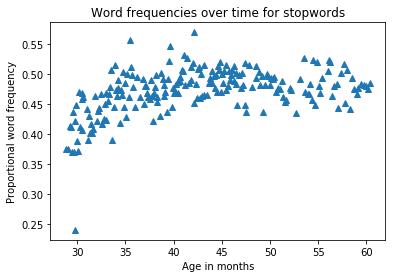

In [8]:
from nltk.corpus import stopwords

en_stopwords = stopwords.words('english')

plot_wordgroup_freq(en_stopwords, transcripts, label='stopwords')

There seems to be a tendency. We could make some calculations, regressions etc., but I'll just stick to the plotting for now.

My idea of working with this particular wordgroup actually arose when I wanted to plot TTR. I had a suspicion that TTR would have a clear growth in young children. However, it was not that clear. Then, I figured that the picture might be skewed by a larger number of tokens of which quite a few would probably be these stopwords. Therefore, I tried to make a function which could disregard some particular words when calculating TTR. Here are both plots:

In [9]:
def plot_ttr(transcripts, child='CHI', speakers=['CHI', 'MOT'], disregard=[]):
    '''Show a plot of the type-to-token-ratio over time with the age of the
    child in months on the x-axis. As a default, the comparison is made with
    the target child and the mother. In case the child has another name code
    than 'CHI', this should be corrected in order to retrieve the age in each
    transcript.'''
    
    # get ages from all transcripts and convert these to months
    ages = [trn.speaker_details()[child]['age'] for trn in transcripts]
    ages = [age_in_months(age) for age in ages]
    
    # get type-to-token-ratios from all trancripts
    for speaker in speakers:
        ttr = [trn.ttr(speakers=speaker, disregard=disregard)
               if speaker in trn.speakers() else None
               for trn in transcripts]
        plt.plot(ages, ttr, '^', label=speaker)
    
    # make it pretty and show the plot
    plt.title('Type-to-token-ratio over time')
    plt.xlabel('Age in months')
    plt.ylabel('TTR')
    plt.legend()
    plt.show()
    
    return

With-counting stopwords.


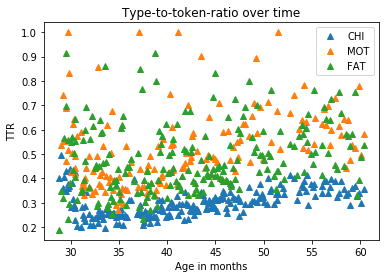

Disregarding stopwords.


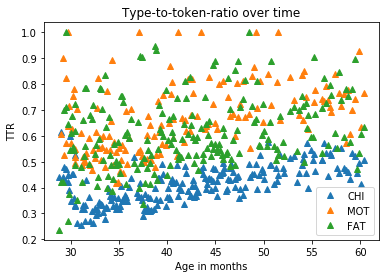

In [10]:
print('With-counting stopwords.')
plot_ttr(transcripts, speakers=['CHI', 'MOT', 'FAT'])

print('Disregarding stopwords.')
plot_ttr(transcripts, speakers=['CHI', 'MOT', 'FAT'], disregard=en_stopwords)

We can try out all the functionality on another longitudinal study which, when we have all the functions and the class defined, is done very quickly. The data is with the British child Lara from a corpus assembled by Caroline Rowland.

In [12]:
folder = '/Users/kasperfyhnjacobsen/Dropbox/Child Language Acquisition/Data/Lara'
en_stopwords = stopwords.words('english')

transcripts = load_all_from_dir(folder)

Growth of the use of stop words


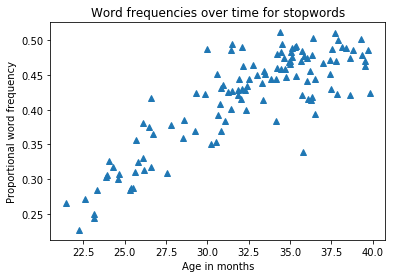

In [13]:
print('Growth of the use of stop words')
plot_wordgroup_freq(en_stopwords, transcripts, label='stopwords')

TTR with-counting stop words


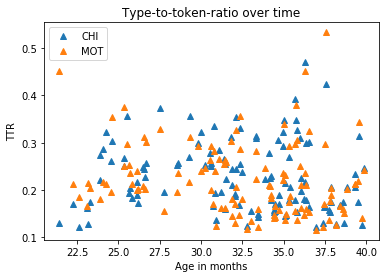

Disregarding stopwords.


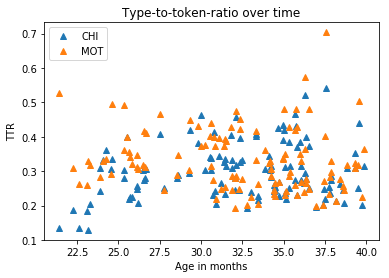

In [15]:
print('TTR with-counting stop words')
plot_ttr(transcripts, speakers=['CHI', 'MOT'])

print('Disregarding stopwords.')
plot_ttr(transcripts, speakers=['CHI', 'MOT'], disregard=en_stopwords)

While these plots are much more scattered, it seems that there may be a point in risregarding stopwords when looking at TTR, as the growth in lexical diversity is clearer.